In [1]:
from refit_dataloader import load_house_csv
import pandas as pd
import numpy as np


agg, app, idx = load_house_csv(r"C:\\Users\\rcper\\OneDrive\Desktop\\Research\\Research(2025)\DSM_and_NILM\SGN_NILM\\CLEAN_REFIT_081116\\CLEAN_House2.csv",
                               appliance_col="Appliance1", max_rows=1000000, resample_rule="8s")  
dt = pd.Series(idx).diff().dropna().median()
print("Cadence:", dt)
print("Zeros% (agg, app):", (agg==0).mean(), (app==0).mean())
print("Std (agg, app):", np.std(agg), np.std(app))
print("Head:", agg[:5], app[:5])


Cadence: 0 days 00:00:08
Zeros% (agg, app): 3e-06 3e-06
Std (agg, app): 620.9564 40.688354
Head: [695. 694. 694. 702. 700.] [88. 88. 88. 88. 88.]


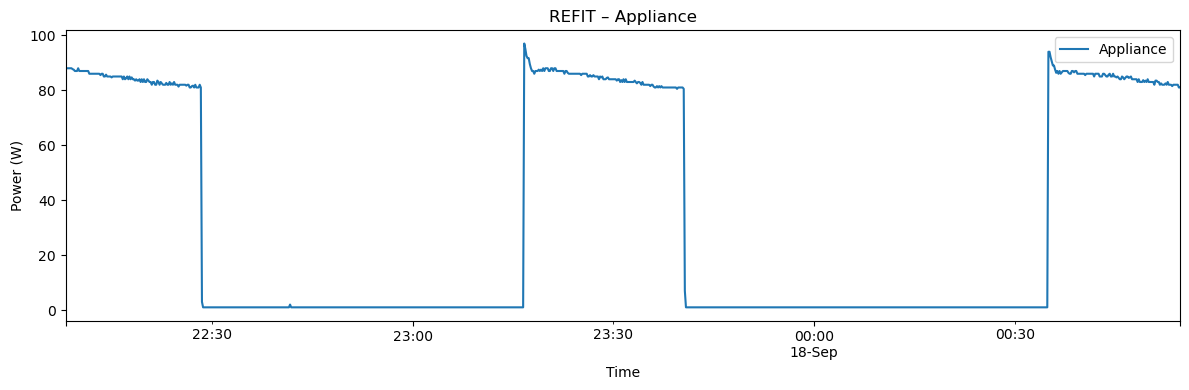

In [5]:
import pandas as pd
from refit_dataloader import load_house_csv

csv_path = r"C:\Users\rcper\OneDrive\Desktop\Research\Research(2025)\DSM_and_NILM\SGN_NILM\CLEAN_REFIT_081116\CLEAN_House2.csv"

# Load arrays + datetime index
agg, app, idx = load_house_csv(
    csv_path,
    appliance_col="Appliance1",   # change as needed
    max_rows=1000,
    resample_rule="10s"           # or "8s", "1min", etc.
)

# Build the DataFrame used by the plotting code
df = pd.DataFrame({"Aggregate": agg, "Appliance": app}, index=idx)

import matplotlib.pyplot as plt

ax = df.plot(y=["Appliance"], figsize=(12, 4))
ax.set_title("REFIT – Appliance")
ax.set_xlabel("Time")
ax.set_ylabel("Power (W)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()



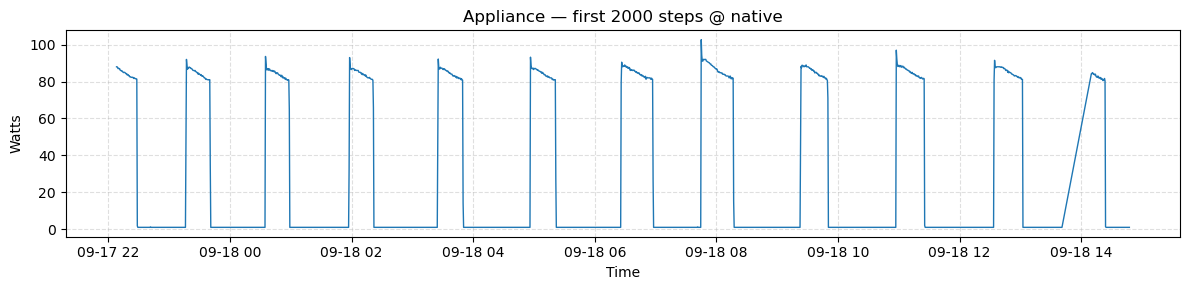

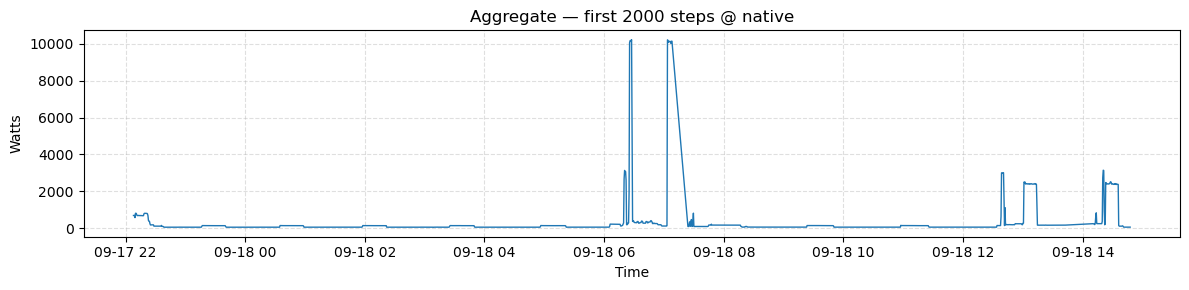

In [4]:
import matplotlib.pyplot as plt


# -----------------------------
# SIMPLE 2000-STEP SNAPSHOTS (separate plots)
# -----------------------------
resample_rule = None  # e.g. "8s", "30s", "1min"; set to None/"" for native cadence

# Resample (if requested)
if resample_rule:
    try:
        df_rs = df.resample(resample_rule).mean()
    except Exception as e:
        print(f"[warn] resample('{resample_rule}') failed ({e}), using native cadence.")
        df_rs = df
else:
    df_rs = df

# Take first 2000 steps (or fewer if not available)
n = min(2000, len(df_rs))
snap = df_rs.iloc[:n]

# Plot Appliance
plt.figure(figsize=(12, 3))
plt.plot(snap.index, snap["Appliance"].values, lw=1)
plt.title(f"Appliance — first {n} steps @ {resample_rule or 'native'}")
plt.xlabel("Time"); plt.ylabel("Watts"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()

# Plot Aggregate
plt.figure(figsize=(12, 3))
plt.plot(snap.index, snap["Aggregate"].values, lw=1)
plt.title(f"Aggregate — first {n} steps @ {resample_rule or 'native'}")
plt.xlabel("Time"); plt.ylabel("Watts"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()


In [4]:
import pandas as pd
import numpy as np

path = r"C:\Users\rcper\OneDrive\Desktop\Research\Research(2025)\DSM_and_NILM\SGN_NILM\CLEAN_REFIT_081116\CLEAN_House2.csv"
appliance_col = "Appliance1"

# --- 1) RAW timestamp cadence (no resample) ---
df = pd.read_csv(path, usecols=["Time", "Aggregate", appliance_col], low_memory=False)
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df = df.dropna(subset=["Time"]).set_index("Time").astype("float32")

dt = df.index.to_series().diff().dropna()
print("Raw dt (describe):")
print(dt.describe())
print("\nMost common dt values:")
print(dt.value_counts().head(5))

# --- 2) INFORMATION cadence: how long values stay constant ---
s = df[appliance_col]
groups = (s != s.shift()).cumsum()
run_len = s.groupby(groups).size()          # run lengths in samples
# map each run to its actual duration using index differences
# (robust to jitter/irregular spacing)
starts = s.groupby(groups).apply(lambda g: g.index[0])
ends   = s.groupby(groups).apply(lambda g: g.index[-1])
run_secs = (ends - starts).dt.total_seconds().clip(lower=0)

print("\nRun duration (seconds) describe:")
print(run_secs.describe())
print("\nTop run durations (seconds):")
print(run_secs.round().value_counts().head(10))


Raw dt (describe):
count                      5733525
mean     0 days 00:00:09.303988732
std      0 days 00:48:02.319539998
min                0 days 00:00:01
25%                0 days 00:00:05
50%                0 days 00:00:07
75%                0 days 00:00:08
max               62 days 00:35:03
Name: Time, dtype: object

Most common dt values:
Time
0 days 00:00:07    2088157
0 days 00:00:01     719539
0 days 00:00:06     597259
0 days 00:00:14     419364
0 days 00:00:02     331344
Name: count, dtype: int64

Run duration (seconds) describe:
count    7.070890e+05
mean     5.609087e+01
std      5.077544e+03
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      1.700000e+01
max      4.234230e+06
Name: Appliance1, dtype: float64

Top run durations (seconds):
Appliance1
0.0     263970
7.0      59297
1.0      42611
2.0      23380
14.0     22988
16.0     20173
6.0      16755
15.0     15996
13.0     14992
3.0      14762
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt


# -----------------------------
# SIMPLE 2000-STEP SNAPSHOTS (separate plots)
# -----------------------------
resample_rule = "30s"  # e.g. "8s", "30s", "1min"; set to None/"" for native cadence

# Resample (if requested)
if resample_rule:
    try:
        df_rs = df.resample(resample_rule).mean()
    except Exception as e:
        print(f"[warn] resample('{resample_rule}') failed ({e}), using native cadence.")
        df_rs = df
else:
    df_rs = df

# Take first 2000 steps (or fewer if not available)
n = min(2000, len(df_rs))
snap = df_rs.iloc[:n]

# Plot Appliance
plt.figure(figsize=(12, 3))
plt.plot(snap.index, snap["Appliance"].values, lw=1)
plt.title(f"Appliance — first {n} steps @ {resample_rule or 'native'}")
plt.xlabel("Time"); plt.ylabel("Watts"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()

# Plot Aggregate
plt.figure(figsize=(12, 3))
plt.plot(snap.index, snap["Aggregate"].values, lw=1)
plt.title(f"Aggregate — first {n} steps @ {resample_rule or 'native'}")
plt.xlabel("Time"); plt.ylabel("Watts"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()


KeyError: 'Appliance'

<Figure size 1200x300 with 0 Axes>